# Introduction

This assignment implements core concepts from machine learning and automatic differentiation.  
In Part A, we simulate sampling from a discrete probability distribution using inverse transform sampling.  
In Part B, we build a simple autograd system from scratch to compute gradients through a computation graph, similar to how modern deep learning frameworks like PyTorch work.



In [1]:
import torch
import matplotlib.pyplot as plt
import math

# **Part A** - Sampling:
In this part we implements a custom sampling method from a discrete probability distribution.
Given a list of probabilities and a desired output shape, it returns random samples drawn according to the specified distribution.
The implementation uses the inverse transform sampling technique, ensuring full control over how sampling works under the hood.


In [2]:
def my_sampler(size, dist, requires_grad=False):
    # Convert the list of probabilities to a torch tensor
    dist = torch.tensor(dist, dtype=torch.float)

    # Input validation
    assert torch.isclose(dist.sum(), torch.tensor(1.0)), "Sum of probabilities must be 1"
    assert torch.all(dist > 0), "All probabilities must be positive"

    # Compute the cumulative distribution
    cum_dist = torch.cumsum(dist, dim=0)

    # Sample uniform random values between 0 and 1 with the desired shape
    uniform_samples = torch.rand(size)

    # Initialize result tensor with -1 to help identify any unassigned positions
    result = torch.full_like(uniform_samples, fill_value=-1.0)

    # Use one loop to assign values based on the intervals in cum_dist
    for i in range(len(dist) - 1):
        lower_bound = cum_dist[i - 1] if i > 0 else 0.0
        upper_bound = cum_dist[i]
        mask = (uniform_samples >= lower_bound) & (uniform_samples < upper_bound)
        result[mask] = float(i)

    # Assign the last index to any values that haven't been assigned yet
    result[result == -1] = float(len(dist) - 1)

    # Return the tensor with or without requires_grad flag
    return result.requires_grad_(requires_grad)

We sample 10,000 values from the discrete distribution \([0.1, 0.2, 0.7]\) using the `my_sampler` function.  
Then, we plot a histogram to visualize the frequency of each sampled category (0, 1, 2).  
This allows us to verify that the sampling procedure reflects the intended probabilities.


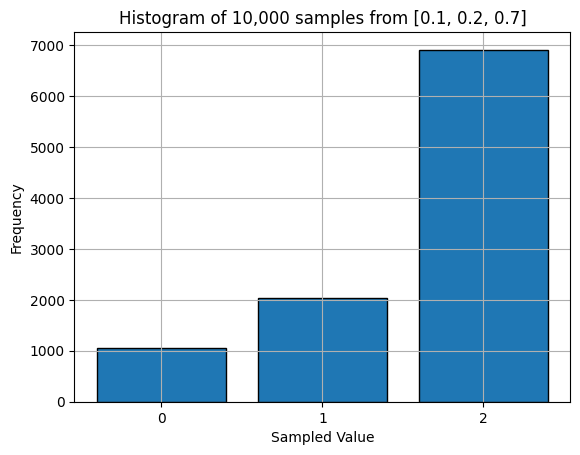

In [3]:
# Sample 10,000 values from the discrete distribution [0.1, 0.2, 0.7]
samples = my_sampler(10000, [0.1, 0.2, 0.7])

# Plot histogram
plt.hist(samples.numpy(), bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8, edgecolor='black')

# Labeling and formatting
plt.xticks([0, 1, 2])
plt.xlabel("Sampled Value")
plt.ylabel("Frequency")
plt.title("Histogram of 10,000 samples from [0.1, 0.2, 0.7]")
plt.grid(True)
plt.show()

# **Part B** - backpropagation:
In this part we implements a basic automatic differentiation system for scalar values.
Each operation (as add, mul, exp) creates a node that stores its value, local gradient, and parent(s).
Using backpropagation via the get_gradient function, the code computes the gradient of the final output with respect to all inputs, similar to how deep learning frameworks handle gradient calculation.



In [4]:
# Class that represents a scalar value in the computation graph
class MyScalar:
    def __init__(self, value, grad=1.0, parent=None, local_grad=1.0):
        self.value = value              # The actual number
        self.grad = 0.0                 # Will be used to store the total gradient
        self.parent = parent            # The previous node
        self.local_grad = local_grad    # How this node changes as its parent changes

# Function to compute a + n, where n is a constant
def add_const(a: MyScalar, n: float):
    value = a.value + n
    local_grad = 1.0  # Derivative of (a + n) is 1
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute a * n, where n is a constant
def mul_const(a: MyScalar, n: float):
    value = a.value * n
    local_grad = n  # Derivative of (a * n) is n
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute a^n and track the gradient
def power(a: MyScalar, n: float):
    value = a.value ** n
    local_grad = n * (a.value ** (n - 1))  # Derivative of a^n is (n * a)^(n-1)
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute e^a and track the gradient
def exp(a: MyScalar):
    value = math.exp(a.value)
    local_grad = value  # Derivative of e^x is e^x
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute ln(a) and track the gradient
def ln(a: MyScalar):
    value = math.log(a.value)
    local_grad = 1 / a.value  # Derivative of ln(x) is 1/x
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute sin(a) and track the gradient
def sin(a: MyScalar):
    value = math.sin(a.value)
    local_grad = math.cos(a.value)  # Derivative of sin(x) is cos(x)
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute cos(a) and track the gradient
def cos(a: MyScalar):
    value = math.cos(a.value)
    local_grad = -math.sin(a.value)  # Derivative of cos(x) is -sin(x)
    return MyScalar(value, parent=a, local_grad=local_grad)

# Function to compute a + b and track both gradients
def add(a: MyScalar, b: MyScalar):
    value = a.value + b.value
    out = MyScalar(value)
    out.parent = (a, b)              # This result depends on both a and b
    out.local_grad = (1.0, 1.0)      # Derivatives: d(a+b)/da = 1, d(a+b)/db = 1
    return out

# Function to compute a * b and track both gradients
def mul(a: MyScalar, b: MyScalar):
    value = a.value * b.value
    out = MyScalar(value)
    out.parent = (a, b)
    out.local_grad = (b.value, a.value)  # Derivatives: d(ab)/da = b, d(ab)/db = a
    return out

# Function to compute a / b and track both gradients
def div(a: MyScalar, b: MyScalar):
    value = a.value / b.value
    out = MyScalar(value)
    out.parent = (a, b)
    out.local_grad = (1 / b.value, -a.value / (b.value ** 2)) # Derivative of a/b: da = 1/b, db = -a/(b^2)
    return out

# This function computes how the output changes as each input changes
def get_gradient(output: MyScalar):
    gradients = {}  # Store final gradients for each input node

    # Recursive function to apply the chain rule from output to inputs
    def backprop(node, grad_contrib):
        if isinstance(node.parent, tuple):
            # Node has two parents like add or multiply
            for i, parent in enumerate(node.parent):
                local = node.local_grad[i]
                backprop(parent, grad_contrib * local)
        elif node.parent is not None:
            # Node has one parent like power or exp
            backprop(node.parent, grad_contrib * node.local_grad)
        else:
            # This is an input variable with no parent
            if node not in gradients:
                gradients[node] = grad_contrib
            else:
                gradients[node] += grad_contrib  # In case multiple paths lead here

    # Start the backpropagation from the final output
    backprop(output, 1.0)

    # Give readable names to the input gradients like x0, x1...
    named_grads = {}
    for i, node in enumerate(gradients.keys()):
        named_grads[f"x{i}"] = gradients[node]
    return named_grads


We perform tests to verify that our custom autograd system produces the same gradients as PyTorch for various functions.


In [5]:
import torch

def test_vs_pytorch():
    print("Comparing our results with PyTorch results:\n")
    TOLERANCE = 1e-5  # Allowed numerical error due to float precision

    # Test 1: f(a) = a^2 at a = 3
    a_val = 3.0
    a = MyScalar(a_val)
    b = power(a, 2)
    our_grad = get_gradient(b)["x0"]

    a_torch = torch.tensor(a_val, requires_grad=True)
    out = a_torch ** 2
    out.backward()
    torch_grad = a_torch.grad.item()

    print("Test 1: f(a) = a^2")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 2: f(a) = exp(a^2) at a = 2
    a_val = 2.0
    a = MyScalar(a_val)
    b = power(a, 2)
    c = exp(b)
    our_grad = get_gradient(c)["x0"]

    a_torch = torch.tensor(a_val, requires_grad=True)
    c_torch = torch.exp(a_torch ** 2)
    c_torch.backward()
    torch_grad = a_torch.grad.item()

    print("Test 2: f(a) = exp(a^2)")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 3: f(a) = ln(a) at a = 4
    a_val = 4.0
    a = MyScalar(a_val)
    b = ln(a)
    our_grad = get_gradient(b)["x0"]

    a_torch = torch.tensor(a_val, requires_grad=True)
    out = torch.log(a_torch)
    out.backward()
    torch_grad = a_torch.grad.item()

    print("Test 3: f(a) = ln(a)")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 4: f(a) = sin(a) at a = π/2
    a_val = math.pi / 2
    a = MyScalar(a_val)
    b = sin(a)
    our_grad = get_gradient(b)["x0"]

    a_torch = torch.tensor(a_val, requires_grad=True)
    out = torch.sin(a_torch)
    out.backward()
    torch_grad = a_torch.grad.item()

    print("Test 4: f(a) = sin(a)")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 5: f(a,b) = a * b at a=2, b=3
    a_val = 2.0
    b_val = 3.0
    a = MyScalar(a_val)
    b = MyScalar(b_val)
    c = mul(a, b)
    grads = get_gradient(c)
    grad_a, grad_b = grads["x0"], grads["x1"]

    a_t = torch.tensor(a_val, requires_grad=True)
    b_t = torch.tensor(b_val, requires_grad=True)
    out = a_t * b_t
    out.backward()
    print("Test 5: f(a,b) = a*b")
    print("Our grad_a:", grad_a, "| PyTorch:", a_t.grad.item())
    print("Our grad_b:", grad_b, "| PyTorch:", b_t.grad.item())
    assert abs(grad_a - a_t.grad.item()) < TOLERANCE
    assert abs(grad_b - b_t.grad.item()) < TOLERANCE
    print("✅ Passed\n")

    # Test 6: f(a,b) = a / b at a=6, b=2
    a_val = 6.0
    b_val = 2.0
    a = MyScalar(a_val)
    b = MyScalar(b_val)
    c = div(a, b)
    grads = get_gradient(c)
    grad_a, grad_b = grads["x0"], grads["x1"]

    a_t = torch.tensor(a_val, requires_grad=True)
    b_t = torch.tensor(b_val, requires_grad=True)
    out = a_t / b_t
    out.backward()
    print("Test 6: f(a,b) = a/b")
    print("Our grad_a:", grad_a, "| PyTorch:", a_t.grad.item())
    print("Our grad_b:", grad_b, "| PyTorch:", b_t.grad.item())
    assert abs(grad_a - a_t.grad.item()) < TOLERANCE
    assert abs(grad_b - b_t.grad.item()) < TOLERANCE
    print("✅ Passed\n")

    # Test 7: add_const(a, 5) at a = 4
    a_val = 4.0
    a = MyScalar(a_val)
    b = add_const(a, 5.0)
    our_grad = get_gradient(b)["x0"]

    a_t = torch.tensor(a_val, requires_grad=True)
    out = a_t + 5.0
    out.backward()
    torch_grad = a_t.grad.item()

    print("Test 7: f(a) = a + 5")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 8: mul_const(a, 5) at a = 4
    a_val = 4.0
    a = MyScalar(a_val)
    b = mul_const(a, 5.0)
    our_grad = get_gradient(b)["x0"]

    a_t = torch.tensor(a_val, requires_grad=True)
    out = a_t * 5.0
    out.backward()
    torch_grad = a_t.grad.item()

    print("Test 8: f(a) = a * 5")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")

    # Test 9: f(a) = ln(exp(a^2)) at a = 2 → f(a) = a^2 → df/da = 4
    a_val = 2.0
    a = MyScalar(a_val)
    b = power(a, 2)
    c = exp(b)
    d = ln(c)
    our_grad = get_gradient(d)["x0"]

    a_t = torch.tensor(a_val, requires_grad=True)
    d_t = torch.log(torch.exp(a_t ** 2))
    d_t.backward()
    torch_grad = a_t.grad.item()

    print("Test 9: f(a) = ln(exp(a^2))")
    print("Our grad:", our_grad, "| PyTorch:", torch_grad)
    assert abs(our_grad - torch_grad) < TOLERANCE
    print("✅ Passed\n")


# Run the test
test_vs_pytorch()


Comparing our results with PyTorch results:

Test 1: f(a) = a^2
Our grad: 6.0 | PyTorch: 6.0
✅ Passed

Test 2: f(a) = exp(a^2)
Our grad: 218.39260013257694 | PyTorch: 218.39259338378906
✅ Passed

Test 3: f(a) = ln(a)
Our grad: 0.25 | PyTorch: 0.25
✅ Passed

Test 4: f(a) = sin(a)
Our grad: 6.123233995736766e-17 | PyTorch: -4.371138828673793e-08
✅ Passed

Test 5: f(a,b) = a*b
Our grad_a: 3.0 | PyTorch: 3.0
Our grad_b: 2.0 | PyTorch: 2.0
✅ Passed

Test 6: f(a,b) = a/b
Our grad_a: 0.5 | PyTorch: 0.5
Our grad_b: -1.5 | PyTorch: -1.5
✅ Passed

Test 7: f(a) = a + 5
Our grad: 1.0 | PyTorch: 1.0
✅ Passed

Test 8: f(a) = a * 5
Our grad: 5.0 | PyTorch: 5.0
✅ Passed

Test 9: f(a) = ln(exp(a^2))
Our grad: 4.0 | PyTorch: 4.0
✅ Passed

